# Modelagem por Machine Learning

Neste notebook vou fazer a modelagem utilizando técnicas de machine learning como AutoML, Feature Selection, GridSearch, entre outras técnicas.

O BD utilizado será o sem as categorias de ignorado e nulo, que permitem uma melhor interpretabilidade dos dados trabalhados sem alterar muito a proporção de 0 e 1 da variável resposta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('SRAG_2020_2021_semignonull.csv', parse_dates=['DT_NOTIFIC'])

df = df[df['tempo_alta_obito_final'] >= 0]

In [3]:
df.head()

,DT_NOTIFIC,tempo_alta_obito_final,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,...,positivo_para4,positivo_adeno,positivo_sars2,positivo_influenza,positivo_metap,positivo_boca,positivo_rino,vacina_covid19,idade1,tempo_alta_obito_final1
0,2020-03-16,159.0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,Nao-disponivel,"(63.0, 75.0]","(85.0, 162.0]"
1,2020-03-14,197.0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,Nao-disponivel,"(63.0, 75.0]","(162.0, 703.0]"
2,2020-05-04,214.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,Nao-disponivel,"(-0.001, 39.0]","(162.0, 703.0]"
3,2020-04-17,3.0,1,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,Nao-disponivel,"(75.0, 121.0]","(-0.001, 14.0]"
4,2020-04-23,15.0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,Nao-disponivel,"(-0.001, 39.0]","(14.0, 36.0]"


In [4]:
df.columns

Index(['DT_NOTIFIC', 'tempo_alta_obito_final', 'febre', 'tosse', 'dispneia',
       'diarreia', 'vomito', 'garganta', 'desc_resp', 'saturacao', 'dor_abd',
       'fadiga', 'perd_olft', 'perd_pala', 'hematologi', 'cardiopati', 'asma',
       'diabetes', 'pneumopati', 'renal', 'imunodepre', 'hepatica',
       'neurologic', 'obesidade', 'puerpera', 'sind_down', 'SG_UF_NOT',
       'idade', 'CS_SEXO', 'gravidez', 'raca', 'vacina_gripe', 'mae_amamenta',
       'mae_vacinada_gripe', 'EVOLUCAO', 'diagnostico', 'antiviral',
       'suporte_vent', 'uti', 'positivo_vsr', 'positivo_para1',
       'positivo_para2', 'positivo_para3', 'positivo_para4', 'positivo_adeno',
       'positivo_sars2', 'positivo_influenza', 'positivo_metap',
       'positivo_boca', 'positivo_rino', 'vacina_covid19', 'idade1',
       'tempo_alta_obito_final1'],
      dtype='object')

In [5]:
df.shape

(247722, 53)

In [6]:
delete_vars = ['raca', 'SG_UF_NOT', 'DT_NOTIFIC', 'idade', 'tempo_alta_obito_final', 'positivo_vsr', 
               'positivo_para1', 'positivo_para2', 'positivo_para3', 'positivo_para4', 'positivo_adeno', 'positivo_sars2', 
               'positivo_influenza', 'positivo_metap', 'positivo_boca', 'positivo_rino']
num_vars = []
dummy_vars = ['gravidez', 'mae_amamenta', 'mae_vacinada_gripe', 'hematologi', 'cardiopati', 'asma', 'diabetes', 'pneumopati', 
              'renal', 'imunodepre', 'hepatica', 'neurologic', 'obesidade', 'puerpera', 'sind_down', 'febre', 'tosse', 
              'dispneia', 'diarreia', 'vomito', 'garganta', 'desc_resp', 'saturacao', 'dor_abd', 'fadiga', 'perd_olft', 
              'perd_pala', 'uti', 'vacina_gripe', 'antiviral']

target = ['EVOLUCAO']

cat_vars = [i for i in df.columns if (i not in delete_vars) and (i not in num_vars) and (i not in dummy_vars) and (i not in target)]

model_vars = cat_vars + num_vars + dummy_vars

In [7]:
cat_vars

['CS_SEXO',
 'diagnostico',
 'suporte_vent',
 'vacina_covid19',
 'idade1',
 'tempo_alta_obito_final1']

### Separando em treino e teste (OOT)

O banco de teste será OOT (Out of time). Pode-se ver pela variável DT_NOTIFIC que o banco vai de 29/12/2019 até 09/12/2021 (provável erro). Vou utilizar como treino os casos do início até 31 de junho de 2021. A partir de 01 de julho de 2021 será utilizado como teste (OOT).

Essa divisão traz uma proporção de, aproximadamente 20,4% para teste

In [8]:
df[['DT_NOTIFIC']].describe(datetime_is_numeric=True)

,DT_NOTIFIC
count,247722
mean,2021-02-04 19:57:00.379296
min,2020-01-04 00:00:00
25%,2020-09-25 00:00:00
50%,2021-03-06 00:00:00
75%,2021-06-14 00:00:00
max,2021-12-11 00:00:00


In [9]:
data_corte = pd.to_datetime('2021-07-01')

df_train = df[df['DT_NOTIFIC'] <= data_corte].reset_index(drop=True).copy()
df_test = df[df['DT_NOTIFIC'] >= data_corte].reset_index(drop=True).copy()

In [10]:
df_train.shape, df_test.shape

((197189, 53), (50565, 53))

In [11]:
df['EVOLUCAO'].value_counts()

0    169189
1     78533
Name: EVOLUCAO, dtype: int64

## Usando o PyCaret

In [12]:
from pycaret.classification import *

In [13]:
exp_setup = setup(
    data=df_train, 
    test_data=df_test, 
    target='EVOLUCAO',
    ignore_features=delete_vars,
    categorical_features=cat_vars, 
    numeric_features=dummy_vars,
    session_id=2020,
    n_jobs = -1
)

,Description,Value
0,session_id,2020
1,Target,EVOLUCAO
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(197189, 53)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
help(get_config)

Help on function get_config in module pycaret.classification:

get_config(variable: str)
    This function retrieves the global variables created when initializing the 
    ``setup`` function. Following variables are accessible:
    
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment par

In [26]:
get_config('X')

,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(-0.001 39.0,idade1_(39.0 52.0,idade1_(52.0 63.0,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0
0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197184,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197185,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
197186,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197187,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
get_config('prep_pipe')

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                            'diagnostico',
                                                            'suporte_vent',
                                                            'vacina_covid19',
                                                            'idade1',
                                                            'tempo_alta_obito_final1'],
                                      display_types=True,
                                      features_todrop=['raca', 'SG_UF_NOT',
                                                       'DT_NOTIFIC', 'idade',
                                                       'tempo_alta_obito_final',
                                                       'positivo_vsr',
                                                       'positivo_para1',
                                                       '

### Treinando vários modelos

In [19]:
best_model = compare_models(sort='f1', fold=None, cross_validation = False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.6500
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,8.2700
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,32.7900
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,25.2800
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.8500
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,5.9100
lda,Linear Discriminant Analysis,0.8029,0.8402,0.5566,0.7311,0.6320,0.5008,0.5095,1.1800
ridge,Ridge Classifier,0.8034,0.7313,0.5475,0.7381,0.6287,0.4989,0.5092,0.1300
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,6.5700
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6458,0.6067,0.4495,0.4511,9.1300


In [21]:
compare_models_results = pull()
compare_models_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.65
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,8.27
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,32.79
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,25.28
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.85
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,5.91
lda,Linear Discriminant Analysis,0.8029,0.8402,0.5566,0.7311,0.6320,0.5008,0.5095,1.18
ridge,Ridge Classifier,0.8034,0.7313,0.5475,0.7381,0.6287,0.4989,0.5092,0.13
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,6.57
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6458,0.6067,0.4495,0.4511,9.13


In [22]:
compare_models_results.to_excel('compare_models_results_com_cat.xlsx')

In [23]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2020, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


O melhor modelo é o LGBM baseline. Vou tunar o modelo lgbm utilizando gridsearch

## LGBM

In [14]:
lgbm = create_model('lightgbm', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7846,0.8300,0.4770,0.7616,0.5866,0.4512,0.4737
1,0.7859,0.8317,0.4820,0.7625,0.5906,0.4555,0.4775
2,0.7911,0.8307,0.5543,0.7287,0.6296,0.4879,0.4967
3,0.7947,0.8377,0.6364,0.6966,0.6652,0.5176,0.5187
4,0.7889,0.8344,0.6244,0.6879,0.6546,0.5032,0.5044
Mean,0.7891,0.8329,0.5548,0.7275,0.6253,0.4831,0.4942
SD,0.0036,0.0028,0.0676,0.0313,0.0321,0.0261,0.0168


### Otimizações

In [28]:
tuned_lgbm = tune_model(lgbm, fold=5, n_iter = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7852,0.8299,0.4822,0.7596,0.5899,0.4541,0.4756
1,0.7868,0.8316,0.4870,0.7614,0.5940,0.4587,0.4798
2,0.7916,0.8315,0.5577,0.7281,0.6316,0.4898,0.4983
3,0.7951,0.8374,0.6355,0.6979,0.6652,0.5180,0.5192
4,0.7901,0.8348,0.6265,0.6898,0.6566,0.5060,0.5072
Mean,0.7897,0.8330,0.5578,0.7274,0.6275,0.4853,0.4960
SD,0.0035,0.0027,0.0656,0.0299,0.0311,0.0253,0.0164


In [30]:
tuned_lgbm = tune_model(lgbm, fold=10, optimize='f1', n_iter=30)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7848,0.8280,0.4988,0.7451,0.5976,0.4584,0.4756
1,0.7863,0.8324,0.4933,0.7548,0.5966,0.4599,0.4791
2,0.7881,0.8312,0.5032,0.7535,0.6035,0.4666,0.4843
3,0.7866,0.8326,0.4953,0.7540,0.5979,0.4609,0.4798
4,0.7915,0.8407,0.5370,0.7408,0.6226,0.4836,0.4955
5,0.8013,0.8414,0.5817,0.7423,0.6522,0.5160,0.5235
6,0.7947,0.8366,0.6184,0.7047,0.6587,0.5128,0.5151
7,0.7991,0.8396,0.6216,0.7144,0.6647,0.5223,0.5249
8,0.7902,0.8341,0.6091,0.6976,0.6503,0.5014,0.5038
9,0.7937,0.8359,0.6171,0.7027,0.6571,0.5105,0.5127


### Otimizações personalizadas

**Otimizações pelo F1**

In [14]:
params = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500, 2000, 5000, 10000],
    'max_depth': [3, 5, 7, 9, 12, 20],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None, 'balanced']
}

In [15]:
tuned_custom = tune_model(estimator        = lgbm, 
                          custom_grid      = params, 
                          fold             = 5, 
                          optimize         = "F1",
                          search_library   = "tune-sklearn", 
                          search_algorithm = "optuna"
                         )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7775,0.8280,0.6585,0.6511,0.6548,0.4907,0.4907
1,0.7786,0.8303,0.6526,0.6551,0.6538,0.4911,0.4911
2,0.7618,0.8300,0.7180,0.6088,0.6589,0.4778,0.4817
3,0.7441,0.8354,0.7871,0.5733,0.6634,0.4651,0.4804
4,0.7388,0.8334,0.7880,0.5664,0.6591,0.4564,0.4728
Mean,0.7602,0.8314,0.7208,0.6110,0.6580,0.4762,0.4833
SD,0.0165,0.0026,0.0591,0.0373,0.0034,0.0138,0.0069


In [16]:
print(tuned_custom)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=5, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=2020,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)


In [20]:
tuned_rand = tune_model(estimator        = lgbm, 
                        custom_grid      = params, 
                        fold             = 5, 
                        optimize         = "F1",
                        search_library   = "scikit-learn", 
                        search_algorithm = "random", 
                        n_iter           = 20
                       )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7777,0.8301,0.6582,0.6514,0.6548,0.4908,0.4908
1,0.7795,0.8318,0.6548,0.6562,0.6555,0.4934,0.4934
2,0.7620,0.8308,0.7186,0.6089,0.6593,0.4783,0.4822
3,0.7434,0.8380,0.7930,0.5718,0.6645,0.4654,0.4818
4,0.7368,0.8347,0.7952,0.5631,0.6594,0.4549,0.4729
Mean,0.7599,0.8331,0.7240,0.6103,0.6587,0.4766,0.4842
SD,0.0174,0.0029,0.0616,0.0388,0.0035,0.0147,0.0073


In [21]:
print(tuned_rand)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.02, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=31, objective=None, random_state=2020,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0)


**Otimizações pelo recall**

In [22]:
tuned_custom_recall = tune_model(estimator        = lgbm, 
                                 custom_grid      = params, 
                                 fold             = 5, 
                                 optimize         = "recall",
                                 search_library   = "tune-sklearn", 
                                 search_algorithm = "optuna"
                                )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7775,0.8285,0.6608,0.6503,0.6555,0.4912,0.4912
1,0.7787,0.8297,0.6509,0.6559,0.6534,0.4909,0.4909
2,0.7596,0.8291,0.7202,0.6049,0.6575,0.4745,0.4788
3,0.7429,0.8354,0.7891,0.5715,0.6629,0.4636,0.4794
4,0.7383,0.8334,0.7899,0.5656,0.6592,0.4561,0.4729
Mean,0.7594,0.8312,0.7222,0.6096,0.6577,0.4753,0.4826
SD,0.0168,0.0027,0.0599,0.0380,0.0033,0.0142,0.0072


In [23]:
print(tuned_custom_recall)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.9, importance_type='split', learning_rate=0.1,
               max_depth=12, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)


### Curva ROC

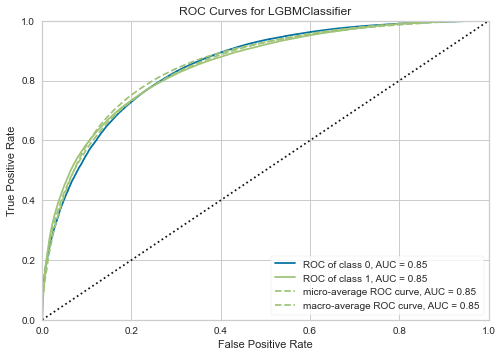

In [25]:
# nos dados de treino
plot_model(tuned_custom, plot = 'auc', use_train_data=True)

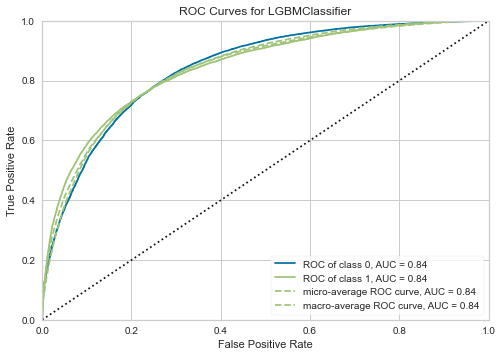

In [26]:
# nos dados de teste
plot_model(tuned_custom, plot = 'auc', use_train_data=False)

### Feature Importance

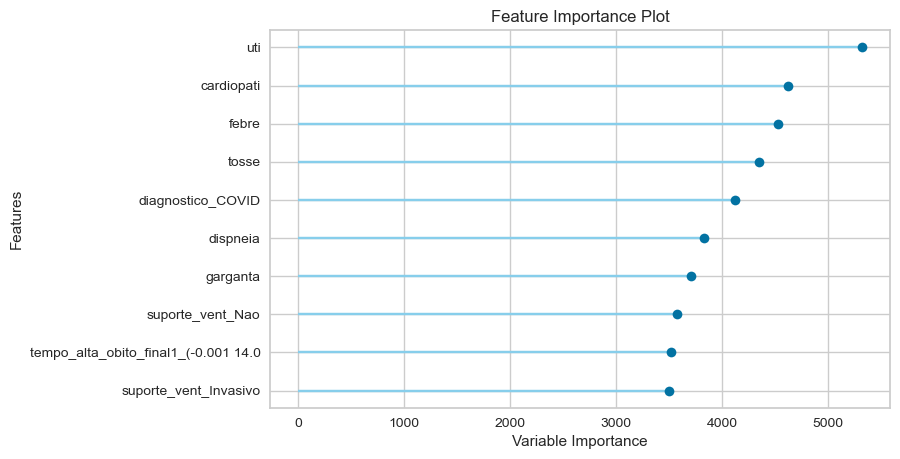

In [27]:
# nos dados de treino
plot_model(tuned_custom, plot='feature', use_train_data=True)

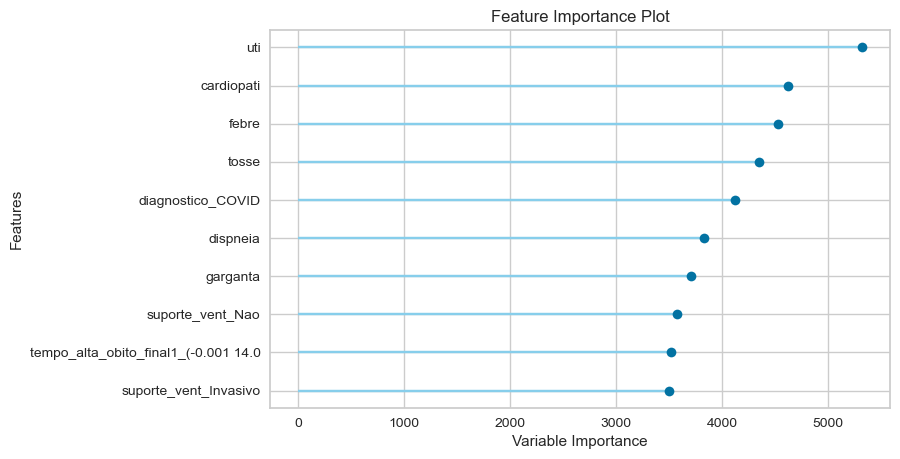

In [28]:
# nos dados de teste
plot_model(tuned_custom, plot='feature', use_train_data=False)

### Matriz de Confusão

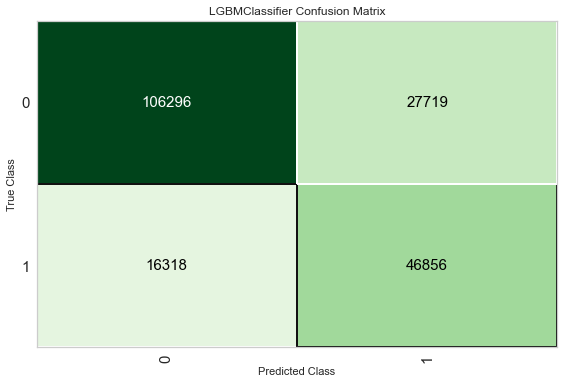

In [29]:
# nos dados de treino
plot_model(tuned_custom, plot='confusion_matrix', use_train_data=True)

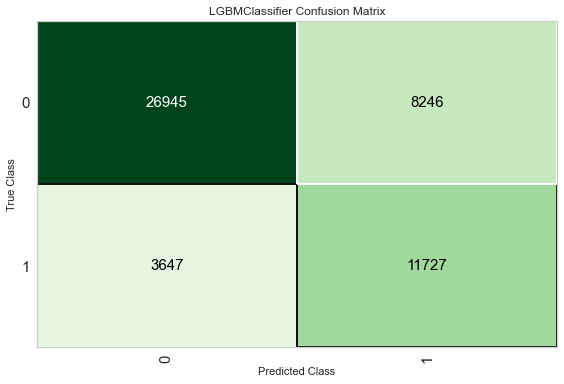

In [30]:
# nos dados de teste
plot_model(tuned_custom, plot='confusion_matrix', use_train_data=False)

### Shap Values

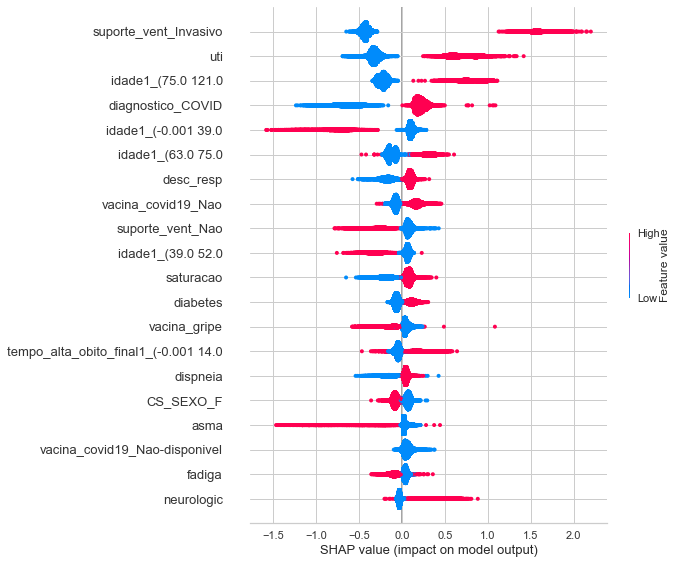

In [31]:
interpret_model(tuned_custom)

In [43]:
evaluate_model(tuned_custom)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [35]:
df_predict = predict_model(tuned_custom)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7648,0.8438,0.7628,0.5871,0.6635,0.4874,0.4973


In [42]:
predict_model(tuned_custom)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7648,0.8438,0.7628,0.5871,0.6635,0.4874,0.4973


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7461
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6555
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.8295
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9411
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8357
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8350
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7413
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8586


## Catboost

In [14]:
catboost = create_model(estimator = 'catboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7833,0.8284,0.4745,0.7587,0.5838,0.4476,0.4702
1,0.7857,0.8303,0.4798,0.7635,0.5893,0.4543,0.4768
2,0.7905,0.8298,0.5585,0.7244,0.6307,0.4879,0.4959
3,0.7930,0.8353,0.6347,0.6932,0.6626,0.5137,0.5148
4,0.7884,0.8326,0.6278,0.6853,0.6553,0.5031,0.5041
Mean,0.7882,0.8313,0.5551,0.7250,0.6244,0.4813,0.4923
SD,0.0034,0.0024,0.0690,0.0322,0.0327,0.0262,0.0167


In [15]:
tuned_catboost = tune_model(catboost, fold=5, optimize = 'F1', n_iter = 100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7845,0.8306,0.4723,0.7652,0.5841,0.4495,0.4733
1,0.7859,0.8320,0.4746,0.7685,0.5868,0.4530,0.4769
2,0.7912,0.8313,0.5490,0.7324,0.6276,0.4867,0.4964
3,0.7971,0.8384,0.6315,0.7045,0.6660,0.5209,0.5225
4,0.7901,0.8349,0.6189,0.6932,0.6539,0.5040,0.5057
Mean,0.7898,0.8334,0.5493,0.7328,0.6237,0.4828,0.4950
SD,0.0044,0.0029,0.0680,0.0307,0.0336,0.0280,0.0183


In [16]:
tuned_catboost_recall = tune_model(catboost, fold=5, optimize = 'Recall', n_iter = 100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7845,0.8304,0.4719,0.7655,0.5839,0.4493,0.4732
1,0.7858,0.8319,0.4738,0.7691,0.5863,0.4527,0.4768
2,0.7916,0.8313,0.5516,0.7320,0.6291,0.4881,0.4976
3,0.7961,0.8381,0.6298,0.7029,0.6644,0.5186,0.5202
4,0.7901,0.8350,0.6204,0.6925,0.6544,0.5044,0.5060
Mean,0.7896,0.8333,0.5495,0.7324,0.6236,0.4826,0.4948
SD,0.0042,0.0028,0.0682,0.0313,0.0335,0.0276,0.0177


In [17]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8048,0.8452,0.5898,0.7179,0.6476,0.5144,0.5191


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.9103
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.7886
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.6289
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8447
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.6818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.9098
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.9134
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.6303
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8642


In [18]:
predict_model(tuned_catboost_recall)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8055,0.8451,0.5911,0.7192,0.6489,0.5162,0.5209


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8992
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.7847
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.6757
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8545
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.6893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.9067
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.9148
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.6150
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8338


## Feature Selection

In [26]:
from feature_engine.encoding import OneHotEncoder

In [27]:
X = df[model_vars].copy()
y = df['EVOLUCAO'].copy()

In [28]:
onehot = OneHotEncoder()

X_transf = onehot.fit_transform(X)

## Removendo Features com Baixa Variância

A ideia aqui é basicamente remover variáveis constante ou com uma variância muito baixa, o que faz com que elas sejam quase constante.

In [29]:
from sklearn.feature_selection import VarianceThreshold

var_sel = VarianceThreshold()
var_sel.fit(X_transf)

VarianceThreshold(threshold=0.0)

In [30]:
variaveis_selecionadas = list(X_transf.columns[var_sel.get_support()])
X_transf[variaveis_selecionadas].head()

,gravidez,mae_amamenta,mae_vacinada_gripe,hematologi,cardiopati,asma,diabetes,pneumopati,renal,imunodepre,...,"idade1_(63.0, 75.0]","idade1_(-0.001, 39.0]","idade1_(75.0, 121.0]","idade1_(52.0, 63.0]","idade1_(39.0, 52.0]","tempo_alta_obito_final1_(85.0, 162.0]","tempo_alta_obito_final1_(162.0, 703.0]","tempo_alta_obito_final1_(-0.001, 14.0]","tempo_alta_obito_final1_(14.0, 36.0]","tempo_alta_obito_final1_(36.0, 85.0]"
0,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [31]:
len(variaveis_selecionadas)

52

Nada mudou!

## Removendo Variáveis Correlacionadas

Podemos criar uma matriz de correlação e remover as variáveis mais correlacionadas entre si. Recomendo sempre testar com e sem as variáveis altamente correlacionadas para ver se melhora o score retirando ou não.

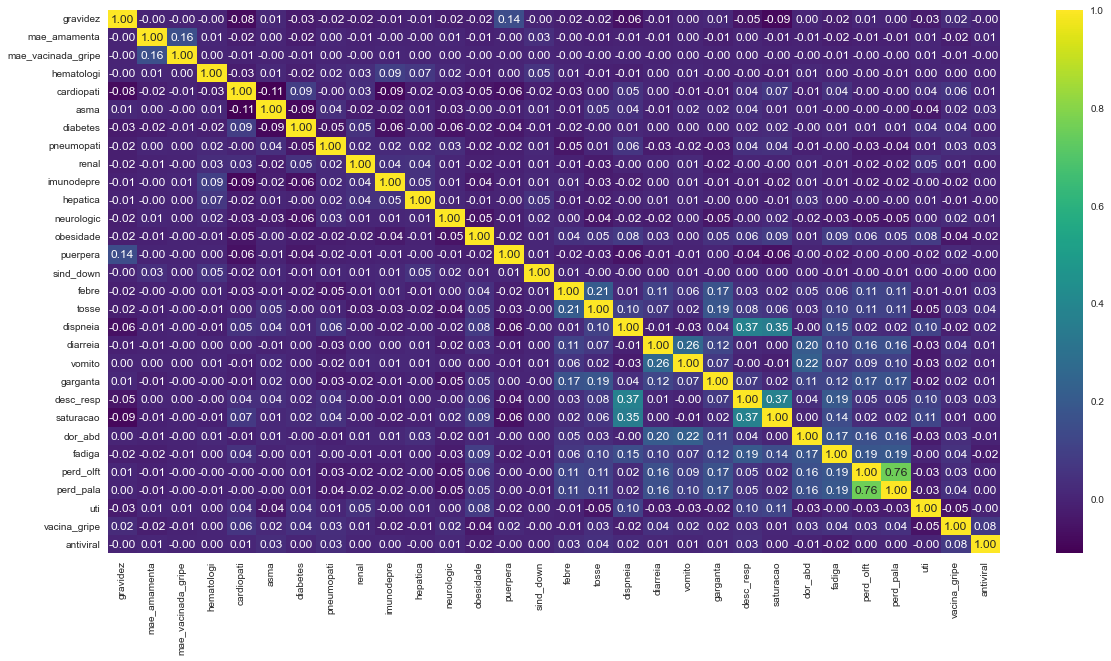

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='viridis', ax=ax);

Não há nada suficientemente correlacionado para ser eliminado. Talvez Perda olfativa/Perda de paladar, mas são sintomas que estão correlacionados na vida real.

## Recursive Feature Elimination

Aqui vamos removendo a variável com menor importância e iterando novamente o treinamento do modelo, a cada passo removendo a variável com menor importância até atingirmos um número mínimo de features especificado.

In [50]:
setup_fe = setup(
    data=df_train, 
    test_data=df_test, 
    target='EVOLUCAO',
    ignore_features=delete_vars,
    categorical_features=cat_vars,
    numeric_features=dummy_vars,
    feature_selection=True,
    feature_selection_method='boruta',
    session_id=2020,
    n_jobs = -1
)

,Description,Value
0,session_id,2020
1,Target,EVOLUCAO
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(197189, 53)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [51]:
lgbm_recall = create_model('lightgbm', fold=5, boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.9, importance_type='split', learning_rate=0.1,
               max_depth=12, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7770,0.8290,0.6590,0.6498,0.6544,0.4898,0.4898
1,0.7782,0.8306,0.6523,0.6543,0.6533,0.4903,0.4903
2,0.7596,0.8294,0.7172,0.6054,0.6566,0.4737,0.4777
3,0.7420,0.8361,0.7886,0.5704,0.6620,0.4620,0.4778
4,0.7371,0.8331,0.7938,0.5637,0.6593,0.4551,0.4728
Mean,0.7588,0.8316,0.7222,0.6087,0.6571,0.4742,0.4817
SD,0.0171,0.0027,0.0607,0.0381,0.0032,0.0143,0.0071


In [52]:
predict_model(lgbm_recall)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7643,0.8438,0.7656,0.5860,0.6638,0.4872,0.4976


,febre,tosse,dispneia,diarreia,garganta,desc_resp,saturacao,fadiga,perd_olft,perd_pala,...,idade1_(39.0 52.0,idade1_(52.0 63.0,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,gravidez,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7577
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.6644
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8004
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9355
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,0.8138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.8250
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0.8398
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.8038
50563,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0.8311


## Blend de 5 modelos tunados

In [15]:
exp_setup = setup(
    data=df_train, 
    test_data=df_test, 
    target='EVOLUCAO',
    ignore_features=delete_vars,
    categorical_features=cat_vars,
    numeric_features=dummy_vars,
    session_id=2020,
    n_jobs = -1
)

,Description,Value
0,session_id,2020
1,Target,EVOLUCAO
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(197189, 53)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
%%time

top5 = compare_models(sort='f1', fold=None, cross_validation = False, n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.4800
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,4.9200
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,31.4100
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,23.8700
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,5.3000
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,5.6800
lda,Linear Discriminant Analysis,0.8029,0.8402,0.5566,0.7311,0.6320,0.5008,0.5095,1.0200
ridge,Ridge Classifier,0.8034,0.7313,0.5475,0.7381,0.6287,0.4989,0.5092,0.1100
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,5.9400
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6459,0.6067,0.4495,0.4511,7.9600


Wall time: 9min 29s


In [15]:
%%time

# tune top 5 base models
tuned_top5 = [tune_model(i, fold = 5, optimize = 'f1') for i in top5]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7735,0.8243,0.6535,0.6444,0.6489,0.4817,0.4818
1,0.7761,0.8252,0.6438,0.6525,0.6481,0.4839,0.4839
2,0.7601,0.8266,0.7091,0.6075,0.6544,0.4723,0.4756
3,0.7442,0.8327,0.7808,0.5741,0.6617,0.4636,0.4778
4,0.7381,0.8302,0.7815,0.5661,0.6566,0.4535,0.4690
Mean,0.7584,0.8278,0.7137,0.6089,0.6539,0.4710,0.4776
SD,0.0152,0.0032,0.0594,0.0353,0.0050,0.0113,0.0052


Wall time: 17min 37s


In [16]:
%%time

# blend top 5 base models 
blender_baseline = blend_models(estimator_list = top5, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7852,0.8280,0.4899,0.7534,0.5938,0.4566,0.4761
1,0.7862,0.8327,0.4863,0.7598,0.5931,0.4574,0.4783
2,0.7874,0.8319,0.4931,0.7586,0.5977,0.4619,0.4817
3,0.7865,0.8327,0.4884,0.7593,0.5944,0.4586,0.4792
4,0.7916,0.8406,0.5265,0.7483,0.6181,0.4807,0.4947
5,0.8024,0.8419,0.5747,0.7502,0.6508,0.5164,0.5253
6,0.7947,0.8367,0.6073,0.7100,0.6547,0.5099,0.5130
7,0.7998,0.8398,0.6141,0.7199,0.6628,0.5217,0.5250
8,0.7913,0.8347,0.6054,0.7022,0.6502,0.5027,0.5055
9,0.7939,0.8360,0.6058,0.7086,0.6532,0.5078,0.5110


Wall time: 5min 33s


In [17]:
%%time

# blend top 5 tuned models
blender_tuned = blend_models(estimator_list = tuned_top5, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7810,0.8246,0.6351,0.6659,0.6501,0.4909,0.4912
1,0.7816,0.8288,0.6300,0.6689,0.6489,0.4906,0.4910
2,0.7811,0.8285,0.6299,0.6678,0.6483,0.4896,0.4900
3,0.7842,0.8291,0.6274,0.6757,0.6506,0.4948,0.4955
4,0.7817,0.8381,0.6630,0.6581,0.6605,0.4996,0.4996
5,0.7824,0.8381,0.6988,0.6491,0.6730,0.5103,0.5111
6,0.7698,0.8344,0.7409,0.6172,0.6734,0.4979,0.5029
7,0.7717,0.8366,0.7420,0.6202,0.6757,0.5017,0.5065
8,0.7614,0.8312,0.7350,0.6052,0.6638,0.4816,0.4871
9,0.7667,0.8329,0.7344,0.6135,0.6685,0.4908,0.4955


Wall time: 5min 56s


In [18]:
# select best model 
best_recall = automl(optimize = 'Recall')

In [19]:
best_recall

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.387, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=240, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', predictor='auto', random_state=2020,
              reg_alpha=3, reg_lambda=0.001,
              scale_pos_weight=24.200000000000003, subsample=0.5,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)

In [20]:
best_f1 = automl(optimize = 'f1')

In [21]:
best_f1

TunableVotingClassifier(estimators=[('lightgbm',
                                     LGBMClassifier(bagging_fraction=0.8,
                                                    bagging_freq=6,
                                                    boosting_type='gbdt',
                                                    class_weight=None,
                                                    colsample_bytree=1.0,
                                                    feature_fraction=0.8,
                                                    importance_type='split',
                                                    learning_rate=0.206,
                                                    max_depth=-1,
                                                    min_child_samples=100,
                                                    min_child_weight=0.001,
                                                    min_split_gain=0.2,
                                                    n_estimators=260, n_jobs=

In [22]:
blender_tuned

TunableVotingClassifier(estimators=[('lightgbm',
                                     LGBMClassifier(bagging_fraction=0.8,
                                                    bagging_freq=6,
                                                    boosting_type='gbdt',
                                                    class_weight=None,
                                                    colsample_bytree=1.0,
                                                    feature_fraction=0.8,
                                                    importance_type='split',
                                                    learning_rate=0.206,
                                                    max_depth=-1,
                                                    min_child_samples=100,
                                                    min_child_weight=0.001,
                                                    min_split_gain=0.2,
                                                    n_estimators=260, n_jobs=

## Testes do modelo que mais otimiza o F1

O modelo é a junção dos 5 melhores modelos com tunning executado.
Os 5 melhores modelos são:
* LightGBM
* XGBoost
* Catboost
* Gradient Boost Classifier
* Logistic Regression

### Curva ROC

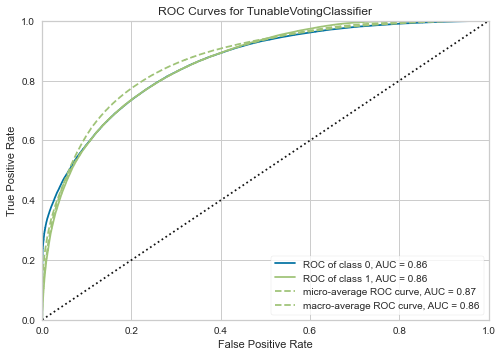

In [23]:
# nos dados de treino
plot_model(blender_tuned, plot = 'auc', use_train_data=True)

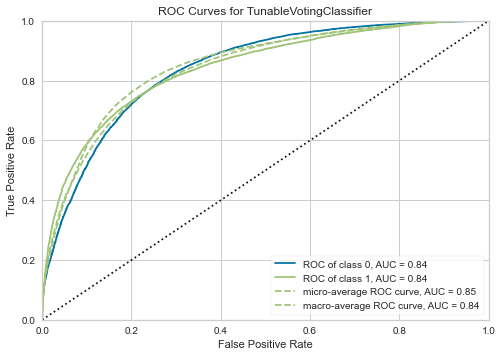

In [24]:
# nos dados de teste
plot_model(blender_tuned, plot = 'auc', use_train_data=False)

### Matriz de confusão

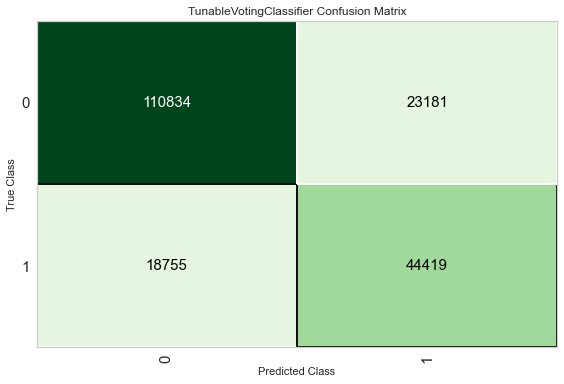

In [25]:
# nos dados de treino
plot_model(blender_tuned, plot='confusion_matrix', use_train_data=True)

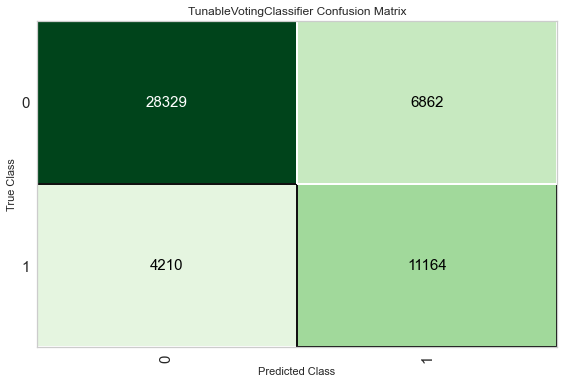

In [26]:
# nos dados de teste
plot_model(blender_tuned, plot='confusion_matrix', use_train_data=False)

In [31]:
predict_model(blender_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7810,0.8424,0.7262,0.6193,0.6685,0.5066,0.5101


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8856
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6457
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7617
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9056
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8716
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8574
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7344
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8268


## Blend de 7 modelos tunados

In [27]:
%%time

top7 = compare_models(sort='f1', fold=None, cross_validation = False, n_select=7)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.4500
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,4.7900
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,32.5100
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,23.4400
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.1800
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,5.5100
lda,Linear Discriminant Analysis,0.8029,0.8402,0.5566,0.7311,0.6320,0.5008,0.5095,1.0400
ridge,Ridge Classifier,0.8034,0.7313,0.5475,0.7381,0.6287,0.4989,0.5092,0.0900
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,5.6500
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6458,0.6067,0.4495,0.4511,7.7400


Wall time: 8min 19s


In [28]:
%%time

# tune top 7 base models
tuned_top7 = [tune_model(i, fold = 5, optimize = 'f1') for i in top7]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7788,0.8055,0.4965,0.7265,0.5898,0.4456,0.4608
1,0.7800,0.8047,0.4965,0.7305,0.5912,0.4481,0.4637
2,0.7815,0.8194,0.5739,0.6916,0.6272,0.4746,0.4787
3,0.7734,0.8194,0.6787,0.6375,0.6575,0.4885,0.4890
4,0.7667,0.8142,0.6675,0.6277,0.6470,0.4730,0.4735
Mean,0.7761,0.8126,0.5826,0.6828,0.6225,0.4659,0.4731
SD,0.0054,0.0065,0.0792,0.0432,0.0279,0.0165,0.0102


Wall time: 24min 3s


In [29]:
%%time

# blend top 7 base models 
blender_baseline_top7 = blend_models(estimator_list = top7, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7856,0.8276,0.4887,0.7557,0.5935,0.4569,0.4769
1,0.7856,0.8323,0.4835,0.7601,0.5910,0.4553,0.4767
2,0.7871,0.8310,0.4907,0.7594,0.5962,0.4605,0.4808
3,0.7868,0.8323,0.4882,0.7605,0.5947,0.4592,0.4800
4,0.7911,0.8400,0.5218,0.7499,0.6154,0.4782,0.4931
5,0.8018,0.8414,0.5677,0.7529,0.6474,0.5133,0.5232
6,0.7954,0.8365,0.6016,0.7146,0.6533,0.5096,0.5134
7,0.8005,0.8397,0.6076,0.7252,0.6612,0.5214,0.5255
8,0.7908,0.8344,0.5950,0.7058,0.6457,0.4987,0.5024
9,0.7940,0.8356,0.5987,0.7125,0.6507,0.5062,0.5101


Wall time: 6min 13s


In [30]:
%%time

# blend top 7 tuned models
blender_tuned_top7 = blend_models(estimator_list = tuned_top7, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7829,0.8241,0.5862,0.6896,0.6337,0.4809,0.4841
1,0.7862,0.8287,0.5797,0.7011,0.6347,0.4855,0.4898
2,0.7838,0.8277,0.5810,0.6943,0.6326,0.4812,0.4850
3,0.7861,0.8284,0.5781,0.7018,0.6340,0.4849,0.4894
4,0.7880,0.8389,0.6242,0.6859,0.6536,0.5013,0.5025
5,0.7910,0.8400,0.6716,0.6746,0.6731,0.5194,0.5194
6,0.7757,0.8342,0.7143,0.6330,0.6712,0.5020,0.5041
7,0.7778,0.8366,0.7156,0.6363,0.6736,0.5061,0.5081
8,0.7689,0.8309,0.7130,0.6215,0.6641,0.4892,0.4919
9,0.7741,0.8324,0.7119,0.6305,0.6687,0.4983,0.5004


Wall time: 8min 6s


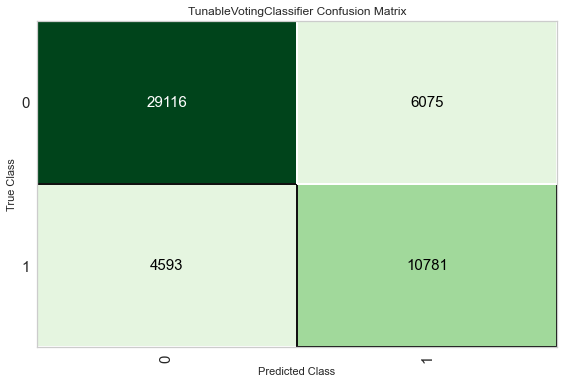

In [33]:
# nos dados de teste
plot_model(blender_tuned_top7, plot='confusion_matrix', use_train_data=False)

## Salvando os modelos

### LightGBM tunado -- SHAP executado e modelo final, melhor recall

In [14]:
lgbm = create_model('lightgbm', fold = 5, boosting_type='gbdt', class_weight='balanced',
                   colsample_bytree=1.0, importance_type='split',
                   learning_rate=0.01, max_depth=5, min_child_samples=20,
                   min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
                   n_jobs=-1, num_leaves=31, objective=None, random_state=2020,
                   reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=0.8,
                   subsample_for_bin=200000, subsample_freq=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7775,0.8280,0.6585,0.6511,0.6548,0.4907,0.4907
1,0.7786,0.8303,0.6526,0.6551,0.6538,0.4911,0.4911
2,0.7618,0.8300,0.7180,0.6088,0.6589,0.4778,0.4817
3,0.7441,0.8354,0.7871,0.5733,0.6634,0.4651,0.4804
4,0.7388,0.8334,0.7880,0.5664,0.6591,0.4564,0.4728
Mean,0.7602,0.8314,0.7208,0.6110,0.6580,0.4762,0.4833
SD,0.0165,0.0026,0.0591,0.0373,0.0034,0.0138,0.0069


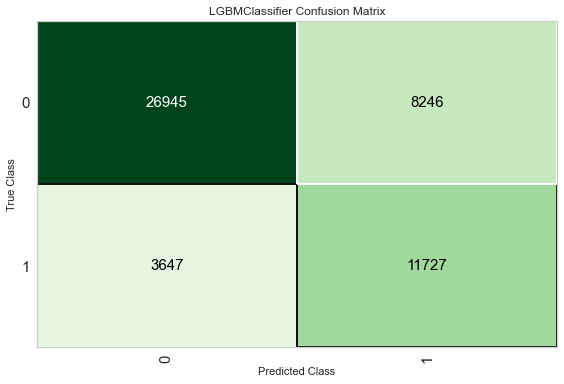

In [15]:
plot_model(lgbm, plot='confusion_matrix', use_train_data=False)

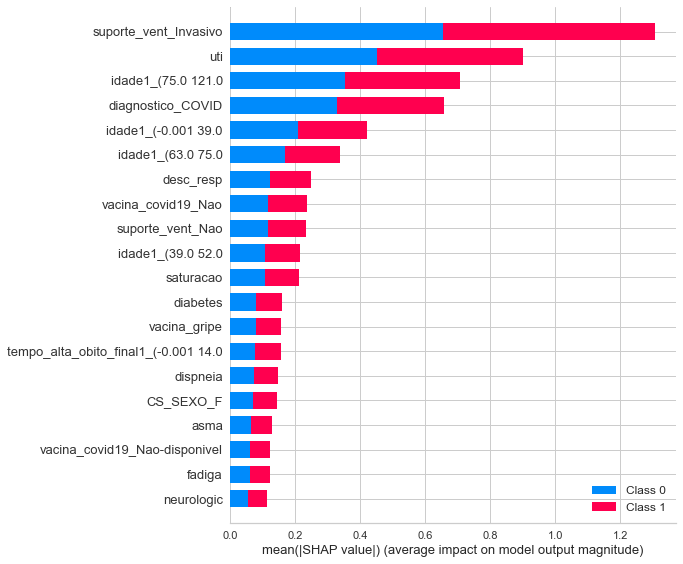

In [16]:
interpret_model(lgbm)

In [19]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [17]:
predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7648,0.8438,0.7628,0.5871,0.6635,0.4874,0.4973


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7461
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6555
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.8295
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9411
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8357
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8350
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7413
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8586


In [45]:
final_model_custom_lgbm = finalize_model(lgbm)

In [46]:
save_model(final_model_custom_lgbm, 'model_tuned_lgbm')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

### Blend 5

In [36]:
final_model_blend5 = finalize_model(blender_tuned)

In [37]:
save_model(final_model_blend5, 'model_blend5')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

### Blend 7

In [38]:
final_model_blend7 = finalize_model(blender_tuned_top7)

In [39]:
save_model(final_model_blend7, 'model_blend7')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

## Ensemble com árvore de decisão

In [13]:
%%time

dt = create_model('dt', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7005,0.6499,0.4780,0.5367,0.5057,0.2919,0.2929
1,0.7044,0.6533,0.4822,0.5436,0.5111,0.3004,0.3015
2,0.6973,0.6610,0.5236,0.5278,0.5257,0.3034,0.3034
3,0.6903,0.6656,0.5785,0.5148,0.5448,0.3113,0.3125
4,0.6889,0.6657,0.5826,0.5128,0.5455,0.3105,0.3120
Mean,0.6963,0.6591,0.5290,0.5271,0.5265,0.3035,0.3045
SD,0.0059,0.0065,0.0450,0.0120,0.0165,0.0071,0.0073


Wall time: 24.8 s


In [14]:
%%time

tuned_dt = tune_model(dt, fold=10, n_iter = 50, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7807,0.8106,0.4918,0.7361,0.5897,0.4480,0.4650
1,0.7806,0.8146,0.4836,0.7415,0.5854,0.4451,0.4639
2,0.7831,0.8121,0.4942,0.7424,0.5934,0.4535,0.4710
3,0.7830,0.8139,0.4904,0.7449,0.5914,0.4521,0.4704
4,0.7841,0.8210,0.5449,0.7134,0.6178,0.4711,0.4794
5,0.7953,0.8235,0.5377,0.7529,0.6273,0.4916,0.5048
6,0.7921,0.8247,0.5947,0.7094,0.6470,0.5012,0.5052
7,0.7979,0.8291,0.5947,0.7251,0.6534,0.5128,0.5178
8,0.7855,0.8226,0.5853,0.6968,0.6362,0.4858,0.4895
9,0.7896,0.8210,0.5867,0.7068,0.6412,0.4942,0.4985


Wall time: 1min 49s


In [15]:
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [16]:
%%time

dt_balanced = create_model('dt', fold = 10, ccp_alpha=0.0, class_weight='balanced', criterion='entropy',
                       max_depth=11, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7598,0.8121,0.6614,0.6167,0.6383,0.4588,0.4594
1,0.7666,0.8155,0.6554,0.6305,0.6427,0.4695,0.4697
2,0.7641,0.8140,0.6641,0.6239,0.6434,0.4674,0.4679
3,0.7684,0.8163,0.6386,0.6385,0.6385,0.4682,0.4682
4,0.7595,0.8221,0.7094,0.6066,0.6540,0.4714,0.4748
5,0.7552,0.8240,0.7229,0.5975,0.6542,0.4673,0.4724
6,0.7395,0.8250,0.7808,0.5680,0.6576,0.4557,0.4707
7,0.7523,0.8297,0.7612,0.5876,0.6632,0.4724,0.4823
8,0.7171,0.8228,0.8039,0.5393,0.6455,0.4250,0.4485
9,0.7300,0.8218,0.7844,0.5557,0.6506,0.4409,0.4583


Wall time: 11.5 s


In [17]:
%%time

bagged_dt = ensemble_model(tuned_dt, method = 'Bagging', optimize='F1', n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7811,0.8165,0.4901,0.7385,0.5892,0.4482,0.4657
1,0.7810,0.8203,0.4830,0.7434,0.5855,0.4457,0.4648
2,0.7836,0.8183,0.4926,0.7454,0.5932,0.4540,0.4721
3,0.7835,0.8195,0.4887,0.7480,0.5912,0.4526,0.4715
4,0.7849,0.8246,0.5382,0.7197,0.6159,0.4708,0.4804
5,0.7956,0.8272,0.5385,0.7532,0.6280,0.4923,0.5055
6,0.7926,0.8280,0.5891,0.7137,0.6455,0.5008,0.5054
7,0.7988,0.8320,0.5910,0.7297,0.6531,0.5136,0.5193
8,0.7857,0.8258,0.5840,0.6979,0.6359,0.4858,0.4897
9,0.7897,0.8256,0.5859,0.7075,0.6410,0.4942,0.4986


Wall time: 6min 25s


In [18]:
%%time

bagged_dt_recall = ensemble_model(tuned_dt, method = 'Bagging', optimize='Recall', n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7811,0.8165,0.4901,0.7385,0.5892,0.4482,0.4657
1,0.7810,0.8203,0.4830,0.7434,0.5855,0.4457,0.4648
2,0.7836,0.8183,0.4926,0.7454,0.5932,0.4540,0.4721
3,0.7835,0.8195,0.4887,0.7480,0.5912,0.4526,0.4715
4,0.7849,0.8246,0.5382,0.7197,0.6159,0.4708,0.4804
5,0.7956,0.8272,0.5385,0.7532,0.6280,0.4923,0.5055
6,0.7926,0.8280,0.5891,0.7137,0.6455,0.5008,0.5054
7,0.7988,0.8320,0.5910,0.7297,0.6531,0.5136,0.5193
8,0.7857,0.8258,0.5840,0.6979,0.6359,0.4858,0.4897
9,0.7897,0.8256,0.5859,0.7075,0.6410,0.4942,0.4986


Wall time: 6min 30s


In [19]:
boosting_dt_f1 = ensemble_model(tuned_dt, method = 'Boosting', optimize='F1', n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7835,0.8219,0.4953,0.7432,0.5945,0.4548,0.4722
1,0.7840,0.8268,0.5002,0.7413,0.5974,0.4572,0.4737
2,0.7847,0.8259,0.5108,0.7364,0.6032,0.4621,0.4766
3,0.7838,0.8249,0.4884,0.7493,0.5913,0.4531,0.4723
4,0.7897,0.8346,0.5389,0.7339,0.6215,0.4805,0.4915
5,0.8003,0.8371,0.5831,0.7386,0.6517,0.5144,0.5215
6,0.7922,0.8302,0.6203,0.6976,0.6567,0.5084,0.5102
7,0.7968,0.8343,0.6364,0.7016,0.6674,0.5216,0.5229
8,0.7863,0.8301,0.6190,0.6840,0.6499,0.4966,0.4979
9,0.7886,0.8291,0.6186,0.6895,0.6521,0.5009,0.5024


In [20]:
boosting_dt_recall = ensemble_model(tuned_dt, method = 'Boosting', optimize='Recall', n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7835,0.8219,0.4953,0.7432,0.5945,0.4548,0.4722
1,0.7840,0.8268,0.5002,0.7413,0.5974,0.4572,0.4737
2,0.7847,0.8259,0.5108,0.7364,0.6032,0.4621,0.4766
3,0.7838,0.8249,0.4884,0.7493,0.5913,0.4531,0.4723
4,0.7897,0.8346,0.5389,0.7339,0.6215,0.4805,0.4915
5,0.8003,0.8371,0.5831,0.7386,0.6517,0.5144,0.5215
6,0.7922,0.8302,0.6203,0.6976,0.6567,0.5084,0.5102
7,0.7968,0.8343,0.6364,0.7016,0.6674,0.5216,0.5229
8,0.7863,0.8301,0.6190,0.6840,0.6499,0.4966,0.4979
9,0.7886,0.8291,0.6186,0.6895,0.6521,0.5009,0.5024


Resultados piores

## Blend de 5 modelos otimizando recall

In [13]:
%%time

top5 = compare_models(sort='f1', fold=None, cross_validation = False, n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.6600
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,9.1400
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,34.8000
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,32.1300
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.6400
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,8.6700
lda,Linear Discriminant Analysis,0.8029,0.8402,0.5566,0.7311,0.6320,0.5008,0.5095,1.2300
ridge,Ridge Classifier,0.8034,0.7313,0.5475,0.7381,0.6287,0.4989,0.5092,0.1800
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,7.3400
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6459,0.6067,0.4495,0.4511,9.7300


Wall time: 10min 58s


In [14]:
%%time

# tune top 5 base models
tuned_top5 = [tune_model(i, fold = 5, optimize = 'Recall') for i in top5]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7735,0.8243,0.6535,0.6444,0.6489,0.4817,0.4818
1,0.7761,0.8252,0.6438,0.6525,0.6481,0.4839,0.4839
2,0.7601,0.8266,0.7091,0.6075,0.6544,0.4723,0.4756
3,0.7442,0.8327,0.7808,0.5741,0.6617,0.4636,0.4778
4,0.7381,0.8302,0.7815,0.5661,0.6566,0.4535,0.4690
Mean,0.7584,0.8278,0.7137,0.6089,0.6539,0.4710,0.4776
SD,0.0152,0.0032,0.0594,0.0353,0.0050,0.0113,0.0052


Wall time: 21min 5s


In [15]:
%%time

# blend top 5 tuned models
blender_tuned_soft = blend_models(estimator_list = tuned_top5, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7808,0.8270,0.6207,0.6705,0.6446,0.4865,0.4872
1,0.7843,0.8325,0.6177,0.6797,0.6472,0.4923,0.4935
2,0.7831,0.8306,0.6125,0.6789,0.6440,0.4886,0.4899
3,0.7861,0.8325,0.6144,0.6853,0.6479,0.4950,0.4965
4,0.7835,0.8402,0.6519,0.6655,0.6586,0.5001,0.5002
5,0.7861,0.8417,0.6871,0.6595,0.6730,0.5142,0.5144
6,0.7754,0.8358,0.7254,0.6298,0.6742,0.5041,0.5071
7,0.7761,0.8388,0.7286,0.6303,0.6759,0.5062,0.5093
8,0.7682,0.8340,0.7240,0.6181,0.6669,0.4909,0.4945
9,0.7714,0.8356,0.7231,0.6235,0.6696,0.4964,0.4996


Wall time: 4min 2s


In [16]:
%%time

# blend top 5 tuned models
blender_tuned_hard = blend_models(estimator_list = tuned_top5, method = 'hard') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7850,0.0000,0.5276,0.7263,0.6112,0.4677,0.4791
1,0.7859,0.0000,0.5200,0.7342,0.6088,0.4673,0.4805
2,0.7874,0.0000,0.5267,0.7344,0.6134,0.4722,0.4846
3,0.7891,0.0000,0.5271,0.7398,0.6156,0.4759,0.4889
4,0.7897,0.0000,0.5642,0.7188,0.6322,0.4879,0.4949
5,0.7997,0.0000,0.6072,0.7232,0.6601,0.5197,0.5236
6,0.7914,0.0000,0.6426,0.6864,0.6638,0.5128,0.5134
7,0.7942,0.0000,0.6523,0.6888,0.6700,0.5206,0.5210
8,0.7852,0.0000,0.6347,0.6754,0.6544,0.4988,0.4994
9,0.7906,0.0000,0.6456,0.6834,0.6640,0.5121,0.5125


Wall time: 3min 53s


In [17]:
blender_tuned_soft

TunableVotingClassifier(estimators=[('lightgbm',
                                     LGBMClassifier(bagging_fraction=0.8,
                                                    bagging_freq=6,
                                                    boosting_type='gbdt',
                                                    class_weight=None,
                                                    colsample_bytree=1.0,
                                                    feature_fraction=0.8,
                                                    importance_type='split',
                                                    learning_rate=0.206,
                                                    max_depth=-1,
                                                    min_child_samples=100,
                                                    min_child_weight=0.001,
                                                    min_split_gain=0.2,
                                                    n_estimators=260, n_jobs=

In [23]:
predict_model(blender_tuned_soft)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7850,0.8448,0.7127,0.6294,0.6685,0.5103,0.5125


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7557
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6207
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7540
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8739
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.7588
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.7440
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.6835
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.6827


In [24]:
final_model_blend5_recall = finalize_model(blender_tuned_soft)

save_model(final_model_blend5_recall, 'model_blend5_recall')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

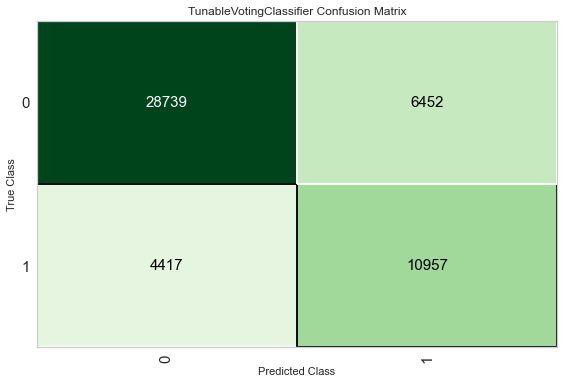

In [25]:
# nos dados de teste
plot_model(blender_tuned_soft, plot='confusion_matrix', use_train_data=False)

## Testando TODOS os modelos salvos

In [13]:
lgbm = load_model('model_tuned_lgbm')

Transformation Pipeline and Model Successfully Loaded


In [14]:
blend5_f1 = load_model('model_blend5')

Transformation Pipeline and Model Successfully Loaded


In [15]:
blend7_f1 = load_model('model_blend7')

Transformation Pipeline and Model Successfully Loaded


In [16]:
blend5_recall = load_model('model_blend5_recall')

Transformation Pipeline and Model Successfully Loaded


## LGBM

In [17]:
predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7648,0.8438,0.7628,0.5871,0.6635,0.4874,0.4973


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7461
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6555
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.8295
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9411
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8357
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8350
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7413
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8586


## Blend 5 com F1 otimizado

In [19]:
predict_model(blend5_f1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7810,0.8424,0.7262,0.6193,0.6685,0.5066,0.5101


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8856
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6457
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7617
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9056
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8716
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8574
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7344
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8268


## Blend 7 com F1 otimizado

In [21]:
predict_model(blend7_f1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7890,0.8428,0.7012,0.6396,0.6690,0.5147,0.5158


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8467
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6648
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7569
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8597
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8298
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8206
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7287
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.7988


## Blend 5 Recall otimizado

In [22]:
predict_model(blend5_recall)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7850,0.8448,0.7127,0.6294,0.6685,0.5103,0.5125


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7557
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6207
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7540
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8739
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.7588
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.7440
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.6835
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.6827


In [23]:
lgbm_recall = create_model('lightgbm', fold=5, boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.9, importance_type='split', learning_rate=0.1,
               max_depth=12, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7775,0.8285,0.6608,0.6503,0.6555,0.4912,0.4912
1,0.7787,0.8297,0.6509,0.6559,0.6534,0.4909,0.4909
2,0.7596,0.8291,0.7202,0.6049,0.6575,0.4745,0.4788
3,0.7429,0.8354,0.7891,0.5715,0.6629,0.4636,0.4794
4,0.7383,0.8334,0.7899,0.5656,0.6592,0.4561,0.4729
Mean,0.7594,0.8312,0.7222,0.6096,0.6577,0.4753,0.4826
SD,0.0168,0.0027,0.0599,0.0380,0.0033,0.0142,0.0072


In [24]:
predict_model(lgbm_recall)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7650,0.8440,0.7656,0.5870,0.6645,0.4885,0.4987


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8300
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6315
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.7272
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9329
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8444
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.8245
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7704
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8865


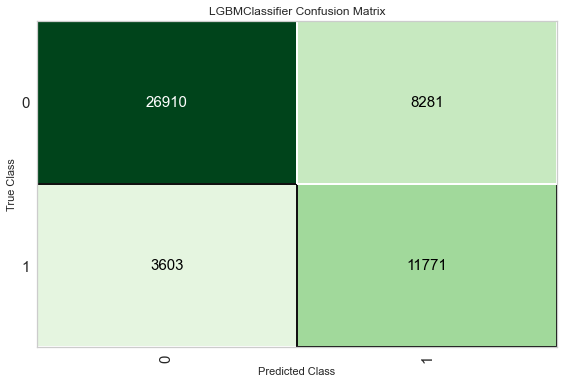

In [25]:
# nos dados de teste
plot_model(lgbm_recall, plot='confusion_matrix', use_train_data=False)

## Teste de Blend com 5 modelos dando sort pelo Recall

In [14]:
%%time

top5 = compare_models(sort='Recall', fold=None, cross_validation = False, n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5350,0.8070,0.9245,0.3887,0.5473,0.2085,0.2975,0.1000
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,8.8600
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.7400
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,33.1800
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,26.0600
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,7.0300
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.7300
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,6.1700
et,Extra Trees Classifier,0.7745,0.7826,0.5721,0.6459,0.6067,0.4495,0.4511,10.0600
knn,K Neighbors Classifier,0.7736,0.7788,0.5596,0.6478,0.6005,0.4437,0.4460,28.1500


Wall time: 11min 14s


In [15]:
top5

[GaussianNB(priors=None, var_smoothing=1e-09),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=1, objective='binary:logistic',
               predictor='auto', random_state=2020, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='auto',
               use_label_encoder=True, validate_parameters=1, verbosity=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
  

In [16]:
%%time

# tune top 5 base models
tuned_top5 = [tune_model(i, fold = 5, optimize = 'Recall') for i in top5]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7824,0.8247,0.4833,0.7484,0.5873,0.4487,0.4685
1,0.7826,0.8254,0.4822,0.7501,0.5870,0.4488,0.4690
2,0.7889,0.8287,0.5574,0.7205,0.6286,0.4845,0.4923
3,0.7901,0.8319,0.6337,0.6868,0.6592,0.5079,0.5087
4,0.7871,0.8287,0.6181,0.6861,0.6503,0.4978,0.4992
Mean,0.7862,0.8279,0.5549,0.7184,0.6225,0.4775,0.4875
SD,0.0032,0.0026,0.0642,0.0281,0.0305,0.0247,0.0162


Wall time: 21min 29s


In [17]:
%%time

# blend top 5 tuned models
blender_tuned = blend_models(estimator_list = tuned_top5, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7449,0.8222,0.7402,0.5798,0.6503,0.4541,0.4625
1,0.7562,0.8274,0.7412,0.5961,0.6607,0.4739,0.4808
2,0.7320,0.8289,0.7844,0.5581,0.6522,0.4441,0.4611
3,0.7542,0.8264,0.7255,0.5955,0.6541,0.4663,0.4718
4,0.7487,0.8368,0.7618,0.5824,0.6601,0.4664,0.4770
5,0.7397,0.8392,0.7923,0.5672,0.6611,0.4591,0.4761
6,0.7125,0.8304,0.8200,0.5334,0.6463,0.4219,0.4497
7,0.7155,0.8324,0.8207,0.5366,0.6489,0.4269,0.4542
8,0.7094,0.8289,0.8240,0.5299,0.6450,0.4181,0.4474
9,0.7126,0.8307,0.8232,0.5333,0.6473,0.4229,0.4514


Wall time: 3min 51s


In [18]:
predict_model(blender_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7243,0.8396,0.8183,0.5302,0.6435,0.4350,0.4623


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7836
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.5281
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.5938
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8917
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.7912
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.6180
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7102
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.6013


Melhoria no Recall

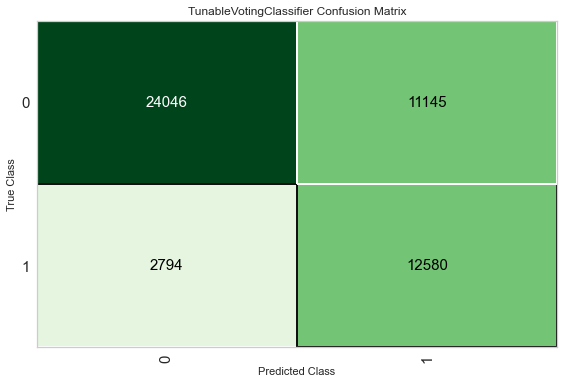

In [19]:
plot_model(blender_tuned, plot='confusion_matrix', use_train_data=False)

In [20]:
final_model_blend5_recall_naive = finalize_model(blender_tuned)

save_model(final_model_blend5_recall_naive, 'model_blend5_recall_naive')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

## Teste de blend com os 15 modelos baseline

In [14]:
%%time

top15 = compare_models(sort='Recall', fold=None, cross_validation = False, n_select=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5350,0.8070,0.9245,0.3887,0.5473,0.2085,0.2975,0.1000
xgboost,Extreme Gradient Boosting,0.8035,0.8426,0.5992,0.7093,0.6496,0.5144,0.5179,8.9200
lightgbm,Light Gradient Boosting Machine,0.8058,0.8452,0.5970,0.7170,0.6515,0.5185,0.5226,0.6600
catboost,CatBoost Classifier,0.8044,0.8428,0.5963,0.7133,0.6495,0.5154,0.5193,33.5900
gbc,Gradient Boosting Classifier,0.8050,0.8443,0.5824,0.7225,0.6449,0.5127,0.5183,24.9800
rf,Random Forest Classifier,0.7832,0.8088,0.5819,0.6637,0.6201,0.4694,0.4714,6.6500
lr,Logistic Regression,0.8035,0.8412,0.5769,0.7210,0.6409,0.5079,0.5139,3.8000
ada,Ada Boost Classifier,0.8034,0.8412,0.5737,0.7225,0.6396,0.5068,0.5132,5.9500
et,Extra Trees Classifier,0.7745,0.7826,0.5720,0.6459,0.6067,0.4495,0.4511,9.8000
knn,K Neighbors Classifier,0.7736,0.7788,0.5596,0.6478,0.6005,0.4437,0.4460,24.7700


Wall time: 11min 35s


In [15]:
%%time

# tune top 5 base models
tuned_top15 = [tune_model(i, fold = 5, optimize = 'Recall') for i in top15]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7685,0.8152,0.6419,0.6378,0.6398,0.4692,0.4693
1,0.7699,0.8173,0.6351,0.6425,0.6388,0.4699,0.4699
2,0.7581,0.8195,0.6897,0.6079,0.6462,0.4635,0.4656
3,0.7269,0.8165,0.7671,0.5532,0.6428,0.4310,0.4461
4,0.7271,0.8145,0.7658,0.5536,0.6426,0.4310,0.4459
Mean,0.7501,0.8166,0.6999,0.5990,0.6420,0.4529,0.4594
SD,0.0193,0.0017,0.0575,0.0391,0.0026,0.0180,0.0110


Wall time: 2h 53min 20s


In [17]:
%%time

# blend top 5 tuned models
blender_tuned = blend_models(estimator_list = tuned_top15, method = 'hard') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7826,0.0000,0.5507,0.7060,0.6188,0.4699,0.4770
1,0.7873,0.0000,0.5474,0.7213,0.6224,0.4782,0.4870
2,0.7840,0.0000,0.5526,0.7088,0.6211,0.4732,0.4804
3,0.7881,0.0000,0.5457,0.7248,0.6226,0.4793,0.4886
4,0.7876,0.0000,0.6061,0.6924,0.6464,0.4955,0.4978
5,0.7983,0.0000,0.6303,0.7082,0.6669,0.5230,0.5248
6,0.7867,0.0000,0.6619,0.6689,0.6654,0.5089,0.5089
7,0.7853,0.0000,0.6861,0.6583,0.6719,0.5125,0.5128
8,0.7790,0.0000,0.6581,0.6543,0.6562,0.4934,0.4934
9,0.7798,0.0000,0.6834,0.6483,0.6654,0.5015,0.5018


Wall time: 25min 50s


In [18]:
predict_model(blender_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7960,0.7568,0.6570,0.6670,0.6619,0.5159,0.5159


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(52.0 63.0,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0


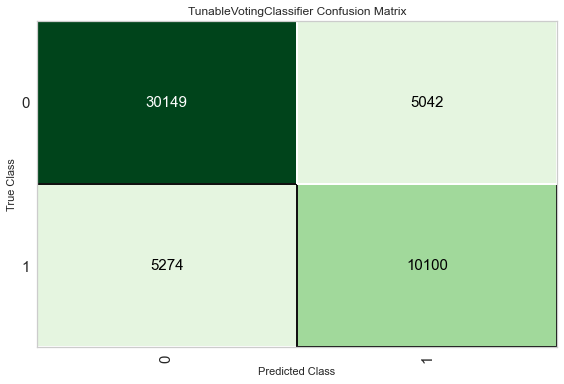

In [52]:
plot_model(blender_tuned, plot='confusion_matrix', use_train_data=False)

## Blend com 13, removendo os modelos que não trabalham com probabilidade

In [43]:
tuned_top15.remove(tuned_top15[12])

In [49]:
tuned_top15.remove(tuned_top15[-2])

In [50]:
blender_tuned_2 = blend_models(estimator_list = tuned_top15, method = 'soft') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7766,0.8238,0.6255,0.6596,0.6421,0.4799,0.4802
1,0.7810,0.8294,0.6237,0.6700,0.6460,0.4878,0.4884
2,0.7812,0.8277,0.6300,0.6680,0.6485,0.4898,0.4903
3,0.7810,0.8291,0.6156,0.6728,0.6430,0.4855,0.4864
4,0.7819,0.8382,0.6579,0.6602,0.6591,0.4988,0.4988
5,0.7823,0.8402,0.6955,0.6498,0.6719,0.5093,0.5100
6,0.7675,0.8327,0.7330,0.6151,0.6689,0.4918,0.4963
7,0.7700,0.8364,0.7354,0.6187,0.6720,0.4970,0.5014
8,0.7621,0.8310,0.7344,0.6062,0.6642,0.4825,0.4879
9,0.7654,0.8323,0.7312,0.6120,0.6663,0.4876,0.4922


In [51]:
predict_model(blender_tuned_2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7791,0.8428,0.7271,0.6158,0.6668,0.5033,0.5072


,febre,tosse,dispneia,diarreia,vomito,garganta,desc_resp,saturacao,dor_abd,fadiga,...,idade1_(63.0 75.0,idade1_(75.0 121.0,tempo_alta_obito_final1_(-0.001 14.0,tempo_alta_obito_final1_(14.0 36.0,tempo_alta_obito_final1_(162.0 703.0,tempo_alta_obito_final1_(36.0 85.0,tempo_alta_obito_final1_(85.0 162.0,EVOLUCAO,Label,Score
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8125
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6270
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.6901
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8573
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50560,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8308
50561,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.7359
50562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,0.7551
50563,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0.7062


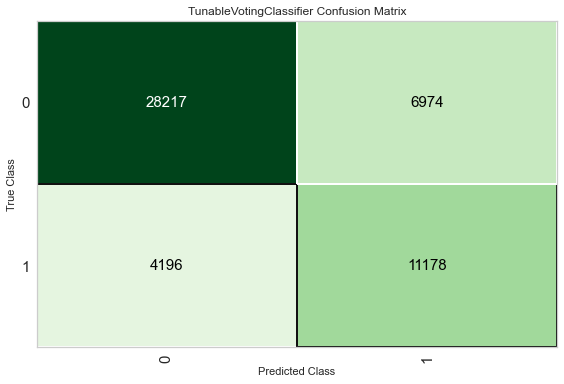

In [53]:
plot_model(blender_tuned_2, plot='confusion_matrix', use_train_data=False)

In [54]:
final_model_blend15 = finalize_model(blender_tuned)

save_model(final_model_blend15, 'model_blend15_recall')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

In [55]:
final_model_blend13 = finalize_model(blender_tuned_2)

save_model(final_model_blend13, 'model_blend13_recall')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CS_SEXO',
                                                             'diagnostico',
                                                             'suporte_vent',
                                                             'vacina_covid19',
                                                             'idade1',
                                                             'tempo_alta_obito_final1'],
                                       display_types=True,
                                       features_todrop=['raca', 'SG_UF_NOT',
                                                        'DT_NOTIFIC', 'idade',
                                                        'tempo_alta_obito_final',
                                                        'positivo_vsr',
                                                        'positivo_para1',
                                          

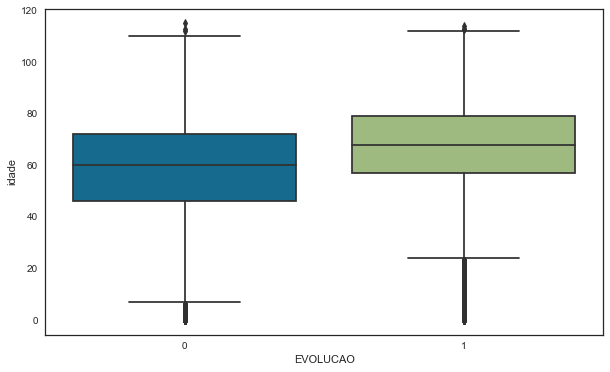

In [57]:
sns.set_style('white')
import seaborn as sns

plt.figure(figsize = (10,6))
plt.ylabel('Idade')
plt.xlabel('Evolução')
sns.boxplot(data = df, x = 'EVOLUCAO', y = 'idade')
plt.show()